We will implement the sum-product Loopy **belief propagation** (Loopy-BP) method for denoising binary images.
We will consider images as matrices of size $\sqrt{n} \times \sqrt{n}$. Each element of the matrix can be either $1$ or $-1$, with $1$ representing white pixels and $-1$ representing black pixels. This is different from the $0/1$ representation commonly used for other CV tasks. This notation will be more convenient when multiplying with pixel values.

### Data preparation


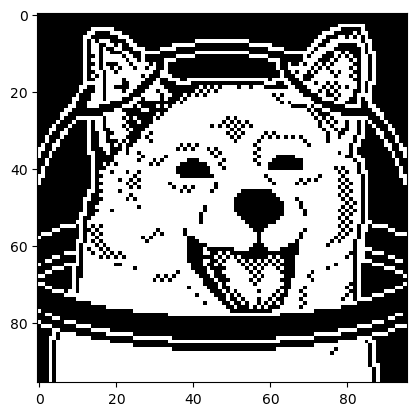

In [34]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm
filename, url = "3vaef0cog4f61.png", "https://i.redd.it/3vaef0cog4f61.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = np.array(img2)
    return (img2[:96,11:107] > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

To introduce noise into the image, for each pixel, swap its value between 1 and -1 with rate 0.2. 


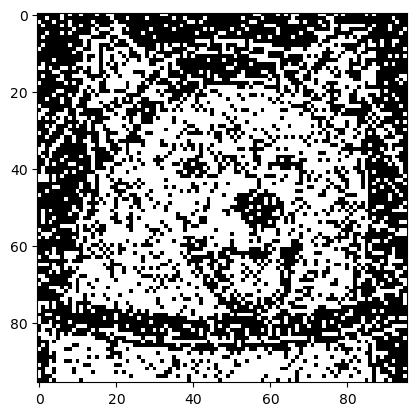

In [35]:
def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (2 * swap - 1)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(-1 * img_noisy, cmap='gray')

### The Loopy BP algorithm


The Loopy-BP algorithm iteratively updates the messages of each node through a sum-product operation. The **sum-product** operation computes the joint inbound message through multiplication, and then marginalizes the factors through summation. This is in contrast to the **max-product** BP, which computes the maximum a-posteriori value for each variable through taking the maximum over variables.

Initialization:
 
For discrete node $x_j$ with $2$ possible states, $m_{i \rightarrow j}$ can be written as a $2$ dimensional real vector $\mathrm{m}_{i,j}$ with $m_{i \rightarrow j}(x_j) =  \mathrm{m}_{i,j}[index(x_j)]$. We initialize them uniformly to $m_{i \rightarrow j}(x_j) = 1/2$. 

(Aside: for continuous cases, $m_{i \rightarrow j}(x_j)$ is a real valued function of $x_j$. We only need to deal with the discrete case here.)

For a number of iterations:

&nbsp;&nbsp;&nbsp;&nbsp;For node $x_j$ in $\{x_s\}_{s=1}^n$:  
1. Compute the product of inbound messages from neighbours of $x_j$: 
$$\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)$$

2. Compute potentials $\psi_j(x_j) = \exp (\beta x_j y_j)$ and $\psi_{ij}(x_i,x_j) = \exp(J x_i x_j)$. This expression specifically holds when $x \in \{-1,+1\}$.

3. Marginalize over $x_j = \{-1, +1\}$ to get $m_{j \rightarrow i}(x_i)$:
$$
m_{j \rightarrow i}(x_i) = \sum_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
4. Normalize messages for stability $m_{j \rightarrow i}(x_i) =m_{j \rightarrow i}(x_i)/\sum_{x_i}m_{j \rightarrow i}(x_i)$.

Compute beliefs after message passing is done.
$$
b(x_i) \propto \psi_i(x_i) \prod_{j \in \mathcal N(i)} m_{j \rightarrow i}(x_i).
$$


### Initialization
Initialize the message between neighbor pixels uniformly as $m_{j→i}(x_i) = 1/k$. Since each pixel can only be 1 or -1, message has two values $m_{j→i}(1)$ and $m_{j→i}(-1)$. We also initialize hyperparameters $J$ and $\beta$.

In [4]:
y = img_noisy.reshape([img_true.size, ])
print(y.shape)
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

(9216,)


Find the neighboring pixels around a given pixel, which will be used for BP updates

In [5]:
def get_neighbors_of(node):
    """
    arguments:
     int node:  in [0,num_nodes) index of node to query
    globals:
     int num_nodes: number of nodes
    return: set(int) indices of neighbors of queried node
    """
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

In [14]:
def get_message(node_from, node_to, messages):
    """
    arguments:
     int node_from: in [0,num_nodes) index of source node
     int node_from: in [0,num_nodes) index of target node
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float array y: (num_nodes,) observed pixel values
     float J: clique coupling strength constant
     float beta: observation to true pixel coupling strength constant
    return: array(float) of shape (2,) un-normalized message from node_from to 
    node_to
    """


    neighbors = get_neighbors_of(node_from)
    possible_values = np.array([-1, 1])

    # compute the product of inbound messages from neighbors of node_from
    prod_term = 1
    for neighbor in neighbors:
        if neighbor != node_to:
            prod_term *= messages[:, neighbor, node_from]

    # compute potentials
    psi_j = np.exp(beta * possible_values * y[node_from])
    psi_ij = np.exp(J * possible_values[:, None] * possible_values[None, :])

    # marginalize over x_j
    sum_term = np.sum(psi_j[:, None] * psi_ij * prod_term[None, :], axis=0)

    # unnormalized message




    unnormalized_message = sum_term * prod_term
    return unnormalized_message


    


def step_bp(step, messages):
    """
    arguments:
     float step: step size to update messages
    return
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    """
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):
            m_new = get_message(node_from, node_to, messages)
            # normalize
            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
    return messages

Then, run loopy BP update for 10 iterations:

In [15]:
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)
    #print(init_message)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


##  Computing belief from messages 


Now, calculate the unnormalized belief for each pixel 
$$ \tilde{b}(x_i) = \psi_i(x_i) ∏_{j \in N(i)}m_{j→i}(x_i),$$
and normalize the belief across all pixels
$$ b(x_i) = \frac{\tilde{b}(x_i)}{∑_{x_j}\tilde{b}(x_j)}.$$ 

In [27]:
#psi = np.zeros((num_nodes, 2))


def update_beliefs(messages):
    """
    arguments:
    float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float beta: observation to true pixel coupling strength constant
     float array y: (num_nodes,) observed pixel values
    returns:
     float array beliefs: (2, num_nodes), beliefs[:,i] is the belief of node i
    """

    possible_values = np.array([-1, 1])
    # compute unnormalized beliefs
    unnormalized_beliefs = np.zeros((2, num_nodes))
    for node in range(num_nodes):
        neighbors = get_neighbors_of(node)
        prod_term = 1
        for neighbor in neighbors:
            prod_term *= messages[:, neighbor, node]
        unnormalized_beliefs[:, node] = np.exp(beta * y[node] * possible_values) * prod_term

    # normalize beliefs
    norm_beliefs = 1 - unnormalized_beliefs / np.sum(unnormalized_beliefs, axis=0)


    
    return norm_beliefs
    

# call update_beliefs() once
#print(init_message)
beliefs = update_beliefs(init_message)

# for testing
#print(beliefs)

[[9.99973500e-01 9.99999995e-01 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 9.99999858e-01]
 [2.64998176e-05 4.56776406e-09 4.33820979e-10 ... 1.83194682e-10
  1.83981497e-10 1.42136482e-07]]


Finally, to get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white. 

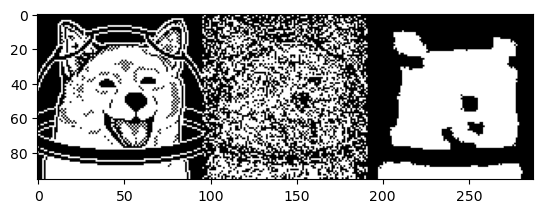

In [88]:
pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)
    
plt.imshow(np.hstack([img_true, -1*img_noisy, img_out]), cmap='gray')

## Momentum in belief propagation




In [89]:
def test_trajectory(step_size, max_step=10):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    # solution:
    for i in range(max_step):
        messages = step_bp(step_size, messages)
        beliefs = update_beliefs(messages)
        pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
        img_out = pred.reshape(img_true.shape)
        images.append(img_out)



    return images

        

C:\Users\Admin\AppData\Local\Temp\ipykernel_7128\796561568.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


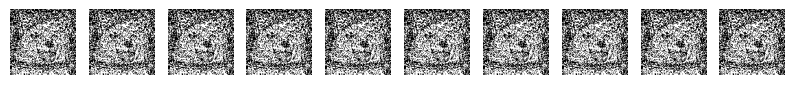

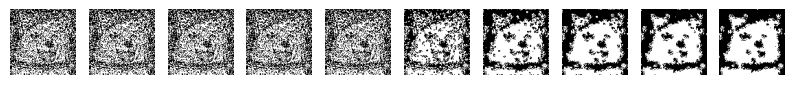

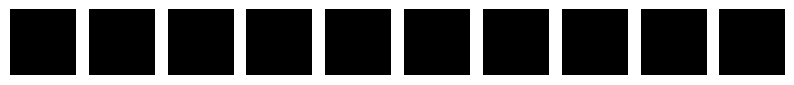

In [90]:
def plot_series(images):
  
  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()

#Solution:
plot_series(test_trajectory(0.1))
plot_series(test_trajectory(0.3))
plot_series(test_trajectory(1.0))

## Noise level, $beta$ and overfitting.


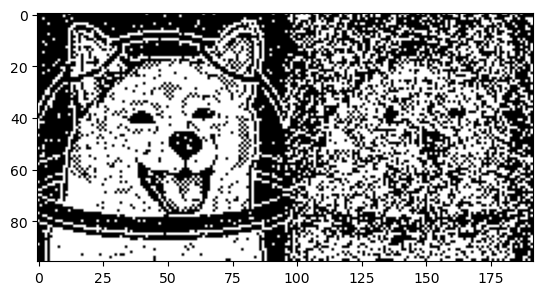

In [91]:
# Solution

# image with noise 0.05
img_noisy_5 = gen_noisyimg(img_true, 0.05)

#image with noise 0.3
img_noisy_30 = gen_noisyimg(img_true, 0.3)

plt.imshow(np.hstack([-1*img_noisy_5, -1*img_noisy_30]), cmap='gray')



C:\Users\Admin\AppData\Local\Temp\ipykernel_7128\796561568.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


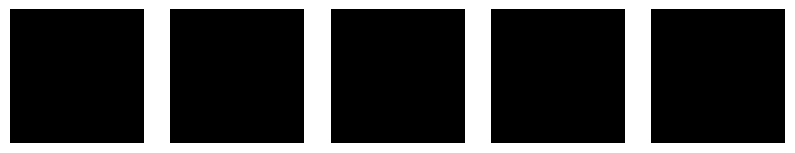

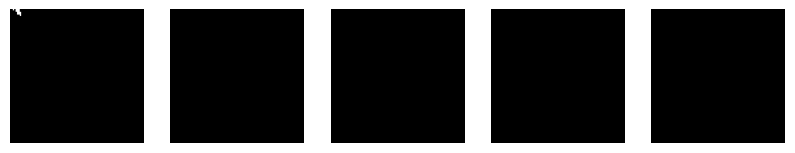

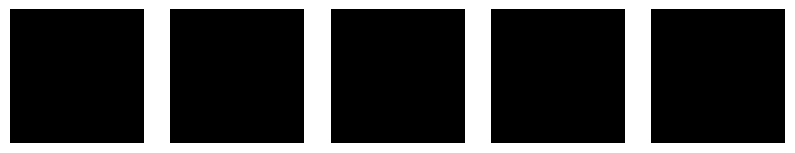

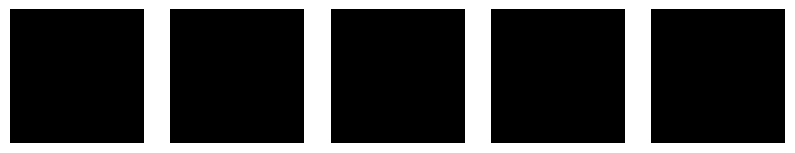

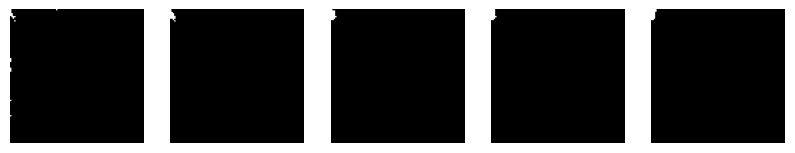

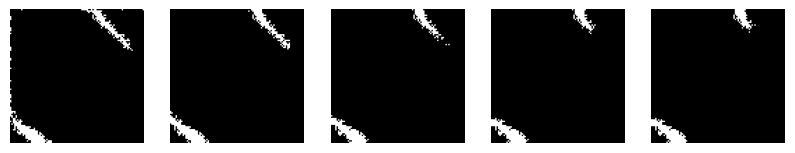

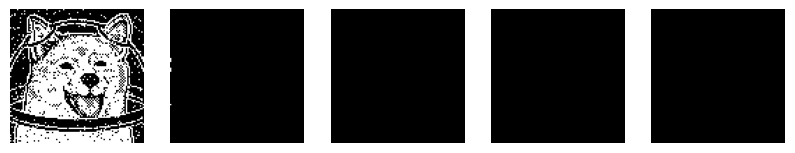

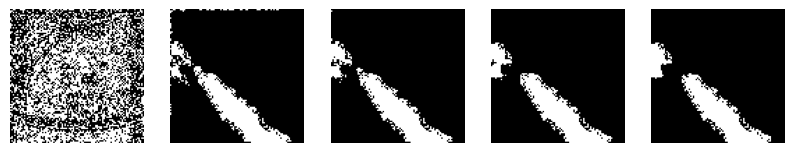

In [92]:
# Solution
step = 0.8
max_step = 5
J = 1.0
betas = [0.5, 1.0, 2.5, 5.0]

for elm in betas:
    beta = elm

    # generate 0.05 noisy image
    img_noisy_5 = gen_noisyimg(img_true, 0.05)
    y = img_noisy_5.reshape([img_true.size, ])
    num_nodes = len(y)
    init_message_5 = np.zeros([2, num_nodes, num_nodes]) + .5

    images = test_trajectory(step, max_step)
    plot_series(images)

    # generate 0.3 noisy image
    img_noisy_30 = gen_noisyimg(img_true, 0.3)
    y = img_noisy_30.reshape([img_true.size, ])
    init_message_30 = np.zeros([2, num_nodes, num_nodes]) + .5

    images_30 = test_trajectory(step, max_step)
    plot_series(images_30)






